In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("Project-HousePrices.xls", index_col=0)

In [3]:
df.head(3)

,sell,lot,bdms,fb,sty,drv,rec,ffin,ghw,ca,gar,reg
obs,,,,,,,,,,,,
1,42000,5850,3,1,2,1,0,1,0,0,1,0
2,38500,4000,2,1,1,1,0,0,0,0,0,0
3,49500,3060,3,1,1,1,0,0,0,0,0,0


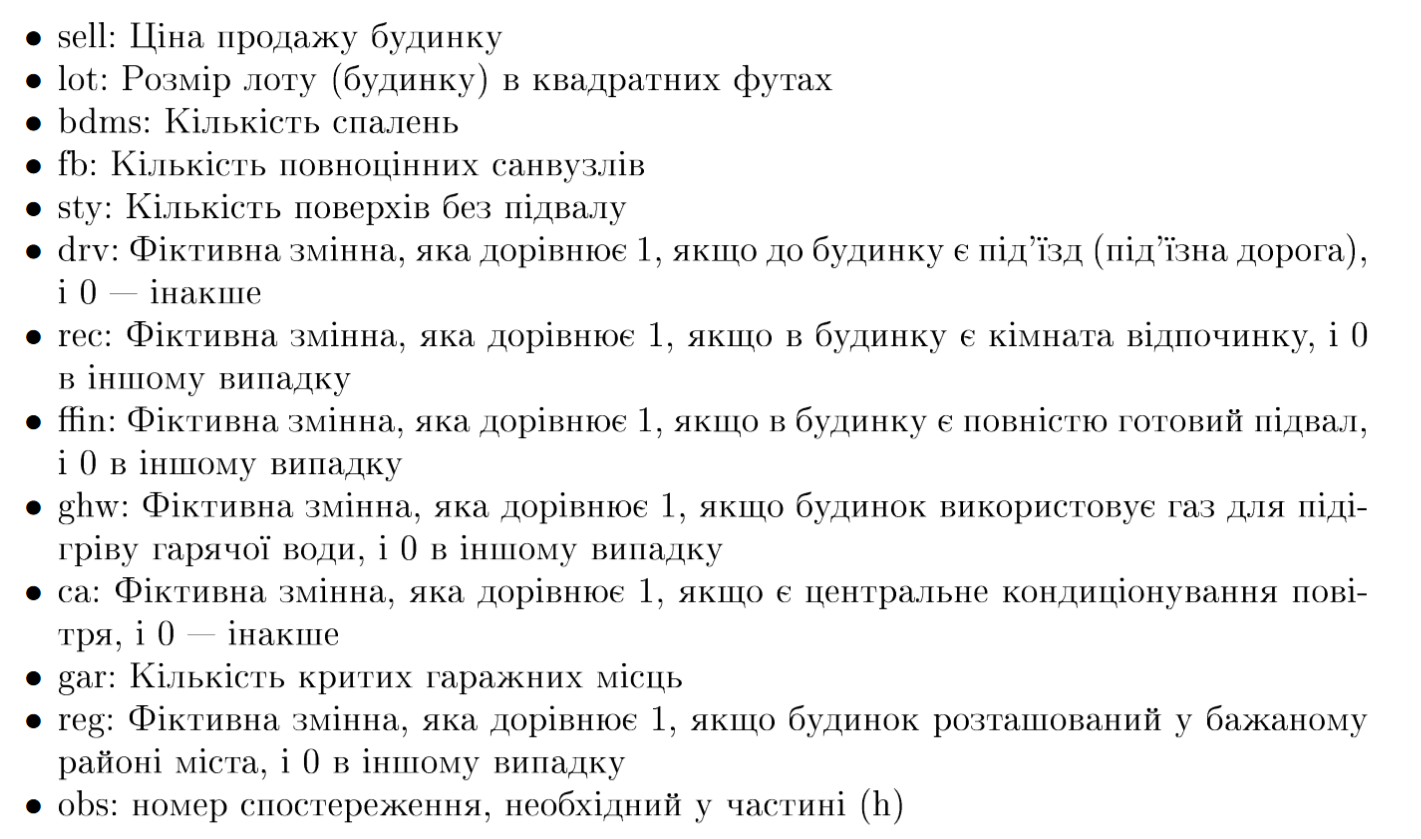

In [4]:
df.shape

(546, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546 entries, 1 to 546
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sell    546 non-null    int64
 1   lot     546 non-null    int64
 2   bdms    546 non-null    int64
 3   fb      546 non-null    int64
 4   sty     546 non-null    int64
 5   drv     546 non-null    int64
 6   rec     546 non-null    int64
 7   ffin    546 non-null    int64
 8   ghw     546 non-null    int64
 9   ca      546 non-null    int64
 10  gar     546 non-null    int64
 11  reg     546 non-null    int64
dtypes: int64(12)
memory usage: 55.5 KB


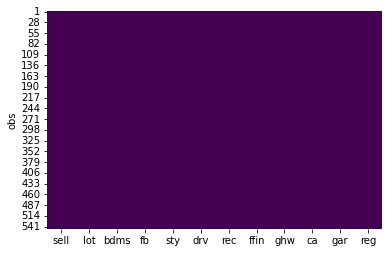

NUMBER OF NULL VALUES PER COLUMN:
sell    0
lot     0
bdms    0
fb      0
sty     0
drv     0
rec     0
ffin    0
ghw     0
ca      0
gar     0
reg     0
dtype: int64


In [6]:
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')
plt.show()
print("\033[4mNUMBER OF NULL VALUES PER COLUMN:\033[0m")
print(df.isnull().sum())
cols_with_nan = df.columns[df.isna().any()].tolist()

<AxesSubplot:xlabel='sell', ylabel='Count'>

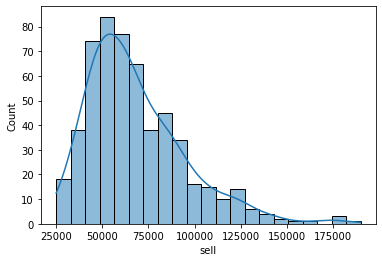

In [7]:
sns.histplot(df.sell, kde=True)

# (a)

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [9]:
X = df.copy()
y = X.pop("sell")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

### Fitting the model

In [10]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

y_pred = lin_reg.predict(X_test)

In [11]:
print("R squared: {}".format(r2_score(y_true=y_test,y_pred=y_pred)))

R squared: 0.6260099661632061


### Mean of Residuals

#### Одним з припущень лінійної регресії є те, що середнє залишків має бути 0. Погляньмо, чи так це в нашому випадку.

In [12]:
residuals = y_test.values - y_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals -316.9484247019774


#### Бачимо, що це не так. Наша лінійна модель доволі погано пояснює наявний розподіл даних.


### Перевірка на гомоскедастичність

Гомоскедастичність означає, що залишки (residuals) мають майже однакові дисперсії (розподіли) вздовж лінії регресії. Виведемо їх на графіку.

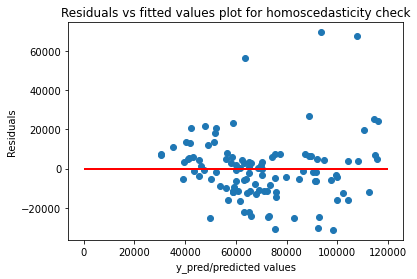

In [13]:
plt.scatter(y_pred, residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.hlines(y=0, xmin=0, xmax=120000, lw=2, color='red')
plt.title('Residuals vs fitted values plot for homoscedasticity check')
plt.show()

#### Тест Голдфелда — Куандта

#### Перевірка гомоскедастичності
- Null Hypothesis: залишки є гомоскедастичними.
- Alternative Hypothesis: залишки є гетероскедастичними.


In [14]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_test)
lzip(name, test)

[('F statistic', 1.0073225964322758), ('p-value', 0.49040209369418003)]

Оскільки p-value більше за 0.05 (p-value ~ 0.49), ми не можемо відкинути нульову гіпотезу.

### Перевірка на нормальний розподіл залишків (residuals)

Text(0.5, 1.0, 'Normality of error terms/residuals')

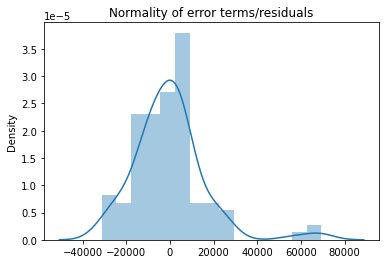

In [15]:
sns.distplot(residuals, kde=True)
plt.title('Normality of error terms/residuals')

Бачимо, що вони доволі нормально розподілені.

### Автокореляція залишків

Автокореляції в ідеалі бути не повинно. І ми на графіку нижче не повинні бачити ніяких паттернів / повторів форм.

Text(0.5, 1.0, 'Residuals vs fitted values plot for autocorrelation check')

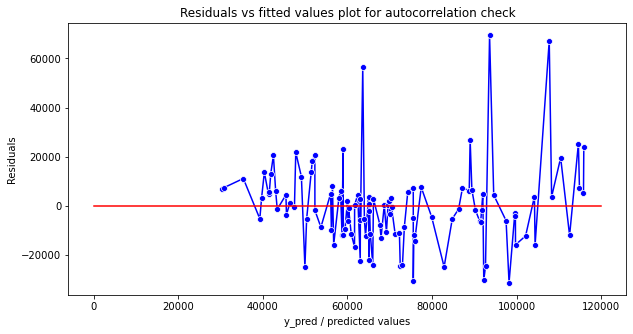

In [16]:
plt.figure(figsize=(10,5))
sns.lineplot(y_pred,residuals,marker='o',color='blue')
plt.xlabel('y_pred / predicted values')
plt.ylabel('Residuals')
sns.lineplot([0,120000],[0,0],color='red')
plt.title('Residuals vs fitted values plot for autocorrelation check')

#### Додатково перевіримо Критерій Льюнга-Бокса

- Null Hypothesis: Автокореляції нема.
- Alternative Hypothesis: Автокореляція присутня.


In [17]:
from statsmodels.stats import diagnostic as diag
min(diag.acorr_ljungbox(residuals , lags = 40)[1])

0.5136983585235726

Отже, з графіка і за допомогою критерія було визначено, що автокореляція таки має місце.

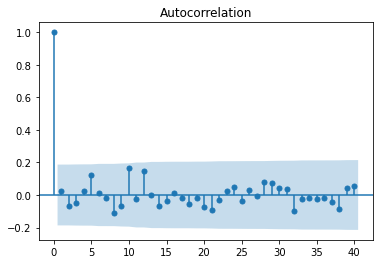

In [18]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

Результат показує знаки автокореляції (шпилі за межами синьої зони confidence interval). Можливо це пов'язано з сезонністю (ми ж аналізуємо зараз ціну на будинки, а вона з сезонами змінюється).

---

# (b)

In [19]:
df.head(3)

,sell,lot,bdms,fb,sty,drv,rec,ffin,ghw,ca,gar,reg
obs,,,,,,,,,,,,
1,42000,5850,3,1,2,1,0,1,0,0,1,0
2,38500,4000,2,1,1,1,0,0,0,0,0,0
3,49500,3060,3,1,1,1,0,0,0,0,0,0


In [20]:
df.sell = np.log(df.sell)

<AxesSubplot:xlabel='sell', ylabel='Count'>

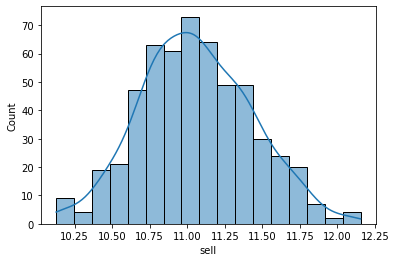

In [21]:
sns.histplot(df.sell, kde=True)

In [22]:
X = df.copy()
y = X.pop("sell")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)


lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

y_pred = lin_reg.predict(X_test)

In [23]:
print("R squared: {}".format(r2_score(y_true=y_test,y_pred=y_pred)))

R squared: 0.6530133355417234


### Mean of Residuals

In [24]:
residuals = y_test.values - y_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals 1.4281555191059619e-05


Цього разу Mean of Residuals справді дуже близько до 0. Ознака кращої моделі, ніж попередня.

### Перевірка на гомоскедастичність

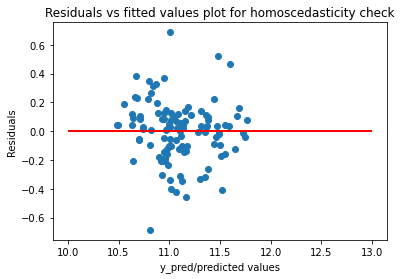

In [25]:
plt.scatter(y_pred, residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.hlines(y=0, xmin=10, xmax=13, lw=2, color='red')
plt.title('Residuals vs fitted values plot for homoscedasticity check')
plt.show()

#### Тест Голдфелда — Куандта

In [26]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_test)
lzip(name, test)

[('F statistic', 1.2170680956577946), ('p-value', 0.2587105643436862)]

p-value is still bigger than 0.05. We can't reject it's null hypothesis that error terms are homoscedastic

### Перевірка на нормальний розподіл залишків (residuals)

Text(0.5, 1.0, 'Normality of error terms/residuals')

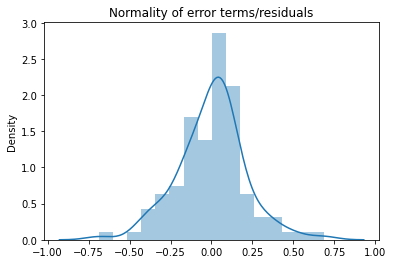

In [27]:
sns.distplot(residuals, kde=True)
plt.title('Normality of error terms/residuals')

### Чи є автокореляція

Text(0.5, 1.0, 'Residuals vs fitted values plot for autocorrelation check')

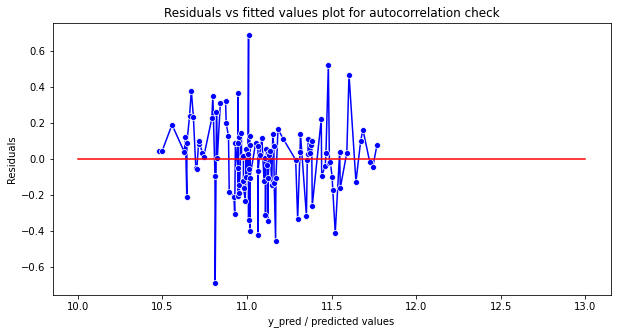

In [28]:
plt.figure(figsize=(10,5))
sns.lineplot(y_pred,residuals,marker='o',color='blue')
plt.xlabel('y_pred / predicted values')
plt.ylabel('Residuals')
sns.lineplot([10,13],[0,0],color='red')
plt.title('Residuals vs fitted values plot for autocorrelation check')

In [29]:
from statsmodels.stats import diagnostic as diag
min(diag.acorr_ljungbox(residuals , lags = 40)[1])

0.49266169786794034

Є. p-value > 0.49

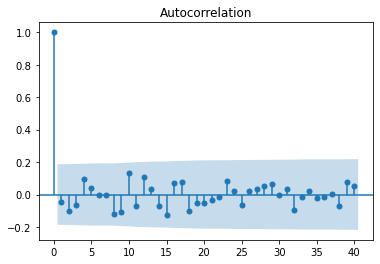

In [30]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

---

# (c)

In [31]:
df.head(3)

,sell,lot,bdms,fb,sty,drv,rec,ffin,ghw,ca,gar,reg
obs,,,,,,,,,,,,
1,10.645425,5850,3,1,2,1,0,1,0,0,1,0
2,10.558414,4000,2,1,1,1,0,0,0,0,0,0
3,10.809728,3060,3,1,1,1,0,0,0,0,0,0


In [32]:
df["lot_log"] = np.log(df.lot)

In [33]:
df.head(3)

,sell,lot,bdms,fb,sty,drv,rec,ffin,ghw,ca,gar,reg,lot_log
obs,,,,,,,,,,,,,
1,10.645425,5850,3,1,2,1,0,1,0,0,1,0,8.674197
2,10.558414,4000,2,1,1,1,0,0,0,0,0,0,8.294050
3,10.809728,3060,3,1,1,1,0,0,0,0,0,0,8.026170


In [34]:
X = df.copy()
y = X.pop("sell")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)


lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

y_pred = lin_reg.predict(X_test)
print("R squared with original lot and log-lot: {}".format(r2_score(y_true=y_test,y_pred=y_pred)))

R squared with original lot and log-lot: 0.660680189805025


In [35]:
df = df.drop(columns=["lot"])

In [36]:
X = df.copy()
y = X.pop("sell")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)


lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

y_pred = lin_reg.predict(X_test)
print("R squared only with log-lot: {}".format(r2_score(y_true=y_test,y_pred=y_pred)))

R squared only with log-lot: 0.6626605324360293


Отже, модель показує кращі результати, якщо ми беремо тільки логарифм від фічi "lot".

---

# (d)

In [37]:
df.head(3)

,sell,bdms,fb,sty,drv,rec,ffin,ghw,ca,gar,reg,lot_log
obs,,,,,,,,,,,,
1,10.645425,3,1,2,1,0,1,0,0,1,0,8.674197
2,10.558414,2,1,1,1,0,0,0,0,0,0,8.294050
3,10.809728,3,1,1,1,0,0,0,0,0,0,8.026170


In [38]:
df.corr()["sell"] #.sort_values(ascending=False)

sell       1.000000
bdms       0.369885
fb         0.484642
sty        0.416115
drv        0.330359
rec        0.276285
ffin       0.217273
ghw        0.088649
ca         0.455913
gar        0.370241
reg        0.339615
lot_log    0.579986
Name: sell, dtype: float64

Бачимо, що змінні 'lot_log', 'fb', 'ca', 'sty' мають високу (вищу за 40%) кореляцію з цільовою змінною.

---

# (e)

### f_regression

In [39]:
from sklearn.feature_selection import f_regression, mutual_info_regression

f_scores, p_values = f_regression(X, y)

### mutual_info_regression

In [40]:
mutual_info = mutual_info_regression(X, y)

In [41]:
stats = pd.DataFrame({
    "feature": X.columns,
    "correlation": df.corr()["sell"].values[1:],
    "f-test": f_scores,
    "mutual_info": mutual_info
})

In [42]:
stats

,feature,correlation,f-test,mutual_info
0,bdms,0.369885,86.223836,0.113628
1,fb,0.484642,166.997351,0.146187
2,sty,0.416115,113.919813,0.133180
3,drv,0.330359,66.643995,0.081702
4,rec,0.276285,44.957266,0.094805
5,ffin,0.217273,26.953402,0.025073
6,ghw,0.088649,4.309012,0.006538
7,ca,0.455913,142.744730,0.118828
8,gar,0.370241,86.416653,0.136993
9,reg,0.339615,70.924508,0.062156


Бачимо, що і F-тест, і спільна значущість показлив такі ж результати, як і кореляційна матриця на попередньому етапі. Найбільший вплив на цільову змінну мають змінні 'lot_log', 'fb', 'ca', тощо.

---

# (f)

In [43]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression

In [44]:
lreg = LinearRegression()

sfs1 = sfs(lreg, k_features=4, forward=False, verbose=1, scoring='neg_mean_squared_error')

In [45]:
sfs1 = sfs1.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s finished
Features: 10/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
Features: 9/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s finished
Features: 8/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
Features: 7/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s finished
Features: 6/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished
Features: 5/4[Parallel(n_job

In [46]:
feat_names = list(sfs1.k_feature_names_)
print(feat_names)

['fb', 'sty', 'reg', 'lot_log']


In [47]:
new_df = df[feat_names]
new_df

,fb,sty,reg,lot_log
obs,,,,
1,1,2,0,8.674197
2,1,1,0,8.294050
3,1,1,0,8.026170
4,1,2,0,8.802372
5,1,1,0,8.757784
...,...,...,...,...
542,2,4,0,8.476371
543,2,4,0,8.699515
544,2,4,0,8.699515


Отже, скориставшись методом backfill elimination, ми визначили лише найбільш вагомі для передбачення ціни змінні.

# (h)

In [56]:
df.head(3)

,sell,bdms,fb,sty,drv,rec,ffin,ghw,ca,gar,reg,lot_log
obs,,,,,,,,,,,,
1,10.645425,3,1,2,1,0,1,0,0,1,0,8.674197
2,10.558414,2,1,1,1,0,0,0,0,0,0,8.294050
3,10.809728,3,1,1,1,0,0,0,0,0,0,8.026170


In [57]:
X = df.drop(columns=["sell"]).copy()

In [58]:
y

obs
1      10.645425
2      10.558414
3      10.809728
4      11.010399
5      11.018629
         ...    
542    11.424094
543    11.451050
544    11.542484
545    11.561716
546    11.561716
Name: sell, Length: 546, dtype: float64

In [59]:
X_train, X_test = X.iloc[:400], X.iloc[400:]
y_train, y_test = y.iloc[:400], y.iloc[400:]

In [60]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

In [61]:
print(mean_absolute_error(y_pred, y_test))

0.12784156874513503


In [65]:
print(r2_score(y_pred, y_test))

0.5493602986174397


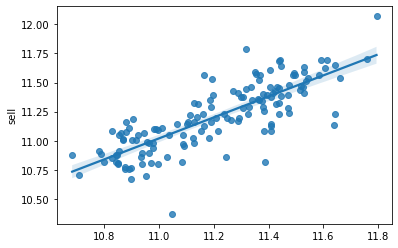

In [64]:
sns.regplot(y_pred, y_test);

## Висновок

Лінійна модель показала себе відносно погано, зокрема через малий датасет і наявність всього однії неперервної змінної, чого для регресії недостатньо. Був проведений аналіз важливості, точніше лінійного зв'язку всіх змінних із цільовою, побудовано графіки і пораховано критерії щодо деяких характеристик лінійної моделі.

Щоб покращити результат передбачення, потрібно знайти більше даних, як рядків, так і колонок, а також спробувати нелінійні алгоритми машинного навчання, як от Random Forest, Light GBM, або навіть нейронну мережу, тощо.